<h1>SkimLit (Milestone Project)</h1>

Created on: July 10, 2021

[https://github.com/mrdbourke/tensorflow-deep-learning](https://github.com/mrdbourke/tensorflow-deep-learning)

Paper: [https://arxiv.org/abs/1710.06071](https://arxiv.org/abs/1710.06071)

In [1]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from tqdm.keras import TqdmCallback
from tensorflow.keras import layers
from sklearn.pipeline import Pipeline
import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
import re

sns.set_theme()

# Data Preparation

In [2]:
%%capture
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

In [3]:
def prepare_data(text_file):
    
    with open(text_file) as file:
        data = file.read()
        content = re.split('\n\n', data)[:-1]

    rows = []
    for record in content:
        lines = record.split('\n')[1:]
        for lineno, line in enumerate(lines):
            rows.append([lineno, len(lines), *line.split('\t')])

    df = pd.DataFrame(rows, columns=['lineno', '# lines', 'target', 'text'])
    return df

In [4]:
train = prepare_data('pubmed-rct/PubMed_20k_RCT/train.txt')
dev = prepare_data('pubmed-rct/PubMed_20k_RCT/dev.txt')
test = prepare_data('pubmed-rct/PubMed_20k_RCT/test.txt')

print(train.shape, dev.shape, test.shape)

(180040, 4) (30212, 4) (30135, 4)


In [57]:
train.sample(10)

,lineno,# lines,target,text
14468,10,11,CONCLUSIONS,The significant prostate-specific antigen prog...
84649,4,13,RESULTS,The control group was cured for 20 seconds by ...
135201,0,15,BACKGROUND,The National Institute for Health and Care Exc...
132084,8,10,RESULTS,Plasma gastrin concentrations did not increase...
38357,2,13,METHODS,The Research Diagnostic Criteria for Temporoma...
129953,4,18,METHODS,"From Jan 28 , 2003 , patients were centrally r..."
155160,1,8,METHODS,A total of 153 cases of early gastroesophageal...
160307,0,11,BACKGROUND,Only a few studies have provided information o...
130823,7,13,RESULTS,"During one-lung ventilation , oxygenation was ..."
58349,1,12,OBJECTIVE,We sought to test a novel IL-23-specific thera...


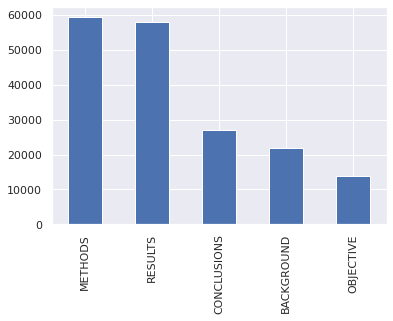

In [5]:
train.target.value_counts().plot.bar();

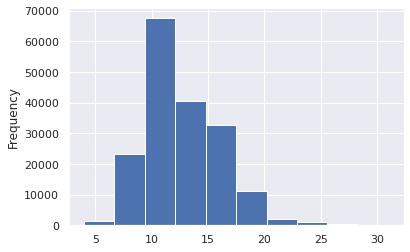

In [6]:
train['# lines'].plot.hist();

In [7]:
x_train = train['text'].to_numpy()
x_dev = dev['text'].to_numpy()
x_test = test['text'].to_numpy()

label_encoder = LabelEncoder()
le_y_train = label_encoder.fit_transform(train['target'])
le_y_dev = label_encoder.fit_transform(dev['target'])
le_y_test = label_encoder.fit_transform(test['target'])

onehot_encoder = OneHotEncoder(sparse=False)
onehot_y_train = onehot_encoder.fit_transform(train["target"].to_numpy().reshape(-1, 1))
onehot_y_dev = onehot_encoder.fit_transform(dev["target"].to_numpy().reshape(-1, 1))
onehot_y_test = onehot_encoder.fit_transform(test["target"].to_numpy().reshape(-1, 1))

In [8]:
label_encoder.classes_

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [50]:
def calculate_results(model, x_val, y_val, ann=False):

    # Predict
    pred = model.predict(x_val)
    if ann:
        pred = np.argmax(pred, axis=-1)
    pred = tf.squeeze(tf.round(pred))

    # Calculate the statistics
    acc = accuracy_score(y_val, pred)
    prec, recall, f1, _ = precision_recall_fscore_support(y_val, pred, average='weighted')
    return {'accuracy': acc, 'precision': prec, 'recall': recall, 'f1': f1}

# Embeddings and Vectorization

In [10]:
np.mean([len(i.split()) for i in x_train])

26.338435903132638

In [11]:
np.percentile([len(i.split()) for i in x_train], 95)

55.0

In [12]:
text_vectorizer = TextVectorization(max_tokens=68000,  # Taken from Paper
                                    output_sequence_length=55,
                                    pad_to_max_tokens=True)

text_vectorizer.adapt(x_train)

In [13]:
words_in_vocab = text_vectorizer.get_vocabulary()
print(words_in_vocab[:5])
print(words_in_vocab[-5:])

['', '[UNK]', 'the', 'and', 'of']
['httpsuploaduminacjpcgiopenbinctrctrcgifunctionbrowsactionbrowstypesummaryrecptnor000008238languagee', 'httpsregisterclinicaltrialsgov', 'httpsmartmicrosurgerycom', 'httpseudractemaeuropaeuindexhtml', 'httpseudractemaeuropaeu']


In [17]:
text_vectorizer.get_config()

{'dtype': 'string',
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': True,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary_size': 68000}

In [18]:
token_embed = layers.Embedding(input_dim=len(words_in_vocab),
                               output_dim=128,
                               mask_zero=True,
                               name='token_embedding')

# 0. Naive Bayes with TF-IDF

In [48]:
model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

model_0.fit(x_train, le_y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [51]:
model0_results = calculate_results(model_0, x_test, le_y_test)
model0_results

{'accuracy': 0.7265637962502074,
 'f1': 0.69938918556014,
 'precision': 0.7218365936390034,
 'recall': 0.7265637962502074}

# 1. Conv1D with token embeddings

In [27]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(5, activation='softmax')(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_1.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 55)                0         
_________________________________________________________________
token_embedding (Embedding)  (None, 55, 128)           8704000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 55, 64)            41024     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
Total params: 8,745,349
Trainable params: 8,745,349
Non-trainable params: 0
_________________________________________________

In [37]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, onehot_y_train))
dev_dataset = tf.data.Dataset.from_tensor_slices((x_dev, onehot_y_dev))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, onehot_y_test))

train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
dev_dataset = dev_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [39]:
h = model_1.fit(train_dataset, epochs=5,
                validation_data=dev_dataset,
                steps_per_epoch=int(0.1 * len(train_dataset)),
                validation_steps=int(0.1 * len(dev_dataset)),
                callbacks=[TqdmCallback(verbose=0)], verbose=0)

In [53]:
model1_results = calculate_results(model_1, x_test, le_y_test, ann=True)
model1_results

{'accuracy': 0.8030197444831592,
 'f1': 0.8003348874055999,
 'precision': 0.8016400040606784,
 'recall': 0.8030197444831592}

# Comparision

In [54]:
stats = pd.DataFrame({'baseline': model0_results,
                      'simple_dense': model1_results})
stats

,baseline,simple_dense
accuracy,0.726564,0.803020
precision,0.721837,0.801640
recall,0.726564,0.803020
f1,0.699389,0.800335


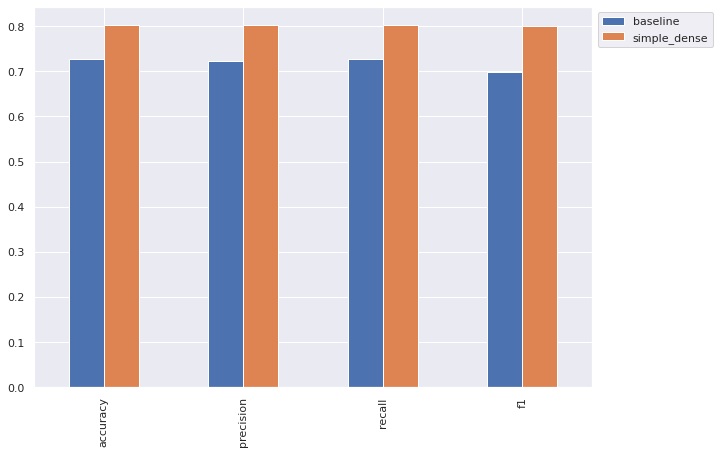

In [55]:
stats.plot(kind='bar', figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));